c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


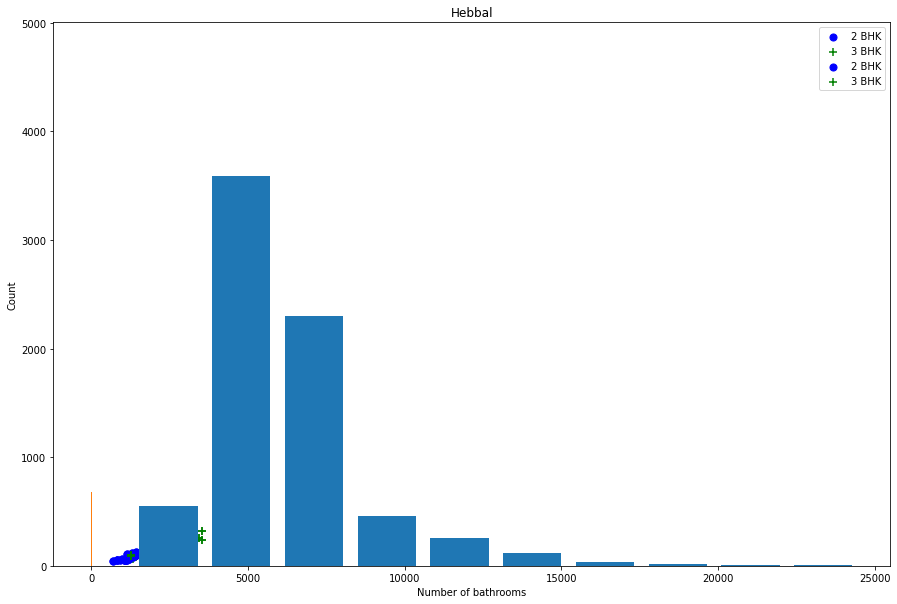

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20, 10)

df1 = pd.read_csv("Bengaluru_House_Data.csv")
df1.head()

df1.shape

## Data Cleanning Process

testd =  df1.groupby('area_type').count()
testd

df1.groupby('area_type')["area_type"].agg("count")  #shows the count of particular area types


df2 = df1.drop(["area_type", "society", "balcony", "availability"], axis="columns") # dropping unnecessary columns

df2.head()

df2.isnull().sum() # counting the missing values for each column

df3 = df2.dropna()  # droping the rows containing any null value
df3.shape

df3.isnull().sum()

# examining size column

df3['size'].unique()

df3['bhk'] = df3['size'].apply(lambda x : int(x.split(" ")[0]))

df3.head()

df3['bhk'].unique()

df3[df3["bhk"] > 20]

# examining total_sqft column
len(df3["total_sqft"].unique())

df3["total_sqft"].unique()

def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

# checking the total sqft values which is not float
df3[~df3["total_sqft"].apply(is_float)].head(10)

def convert_sqft_to_num(x):
    tokens = x.split("-")
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1]))/2
    
    try:
        return float(x)
    except:
        return None

convert_sqft_to_num("2166")

convert_sqft_to_num("2100-2850")

convert_sqft_to_num("34.46Sq. Meter	")

df4 = df3.copy()
df4["total_sqft"] = df4["total_sqft"].apply(convert_sqft_to_num)
df4.head(10)

df4.iloc[30]

df4.shape

df4.loc[410]

## Feature Engineering

df5 = df4.copy()

# creating price_per_sqft column

df5["price_per_sqft"] = df5["price"]*100000 / df5["total_sqft"]
df5.head(10)

# examining the location column

df5["location"].unique()

len(df5["location"].unique())

df5["location"] = df5["location"].apply(lambda x : x.strip()) # remove trailing and leading space

location_stats = df5.groupby("location")['location'].agg("count").sort_values(ascending = False)  # finding the count of unique locations
location_stats

len(location_stats[location_stats <= 10])

location_stats_less_than_10 = location_stats[location_stats <= 10]
location_stats_less_than_10

# making the location attribute "other" if the count of the location is <= 10
df5["location"] = df5["location"].apply(lambda x : "other" if x in location_stats_less_than_10 else x)  
df5.head(10)

len(df5["location"].unique()) #now we have only 242 unique location

## Outlier Removal

# Outliers are data points which are not valid, may be error,or they may be valid 
# but can cause extreme variation in dataset values

# we are finding the flats where size of a room in very small say less than 300 sqft
# We are considering them anomaly

df5[df5["total_sqft"] / df5["bhk"] < 300].head(10)

df5.shape

df6 = df5[~(df5["total_sqft"] / df5["bhk"] < 300)]  # removing those anomalies

df6.shape

# checking the price_per_sqft column

df6["price_per_sqft"].describe()

def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby("location"):
        m = np.mean(subdf["price_per_sqft"])
        st = np.std(subdf["price_per_sqft"])
        
        reduced_df = subdf[(subdf["price_per_sqft"] > (m-st)) & (subdf["price_per_sqft"] <= (m+st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index = True)
    return df_out

df7 = remove_pps_outliers(df6)

df7.shape

def plot_scatter_chart(df, location):
    bhk2 = df[(df["location"] == location) & (df["bhk"] == 2)]
    bhk3 = df[(df["location"] == location) & (df["bhk"] == 3)]
    
    matplotlib.rcParams["figure.figsize"] = (15, 10)
    plt.scatter(bhk2["total_sqft"], bhk2["price"], color="blue", label="2 BHK", s = 50)
    plt.scatter(bhk3["total_sqft"], bhk3["price"], marker = "+", color="green", label="3 BHK", s = 50)
    
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7, "Hebbal")

def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    
    for location, location_df in df.groupby("location"):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby("bhk"):
            bhk_stats[bhk] = {
                "mean": np.mean(bhk_df["price_per_sqft"]),
                "std": np.std(bhk_df["price_per_sqft"]),
                "count": bhk_df.shape[0]
            }
            
        for bhk, bhk_df in location_df.groupby("bhk"):
            stats = bhk_stats.get(bhk-1)
            if stats and stats["count"] > 5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df["price_per_sqft"] < (stats["mean"])].index.values)
    return df.drop(exclude_indices, axis = "index")


df8 = remove_bhk_outliers(df7)

df8.shape

plot_scatter_chart(df8, "Hebbal")

matplotlib.rcParams["figure.figsize"] = (20, 10)
plt.hist(df8["price_per_sqft"], rwidth = 0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

# exploring bathroom features
df8["bath"].unique()

df8[df8["bath"] > 10]

plt.hist(df8["bath"], rwidth = 0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

#removing bathroom outliers (number of bathroom > no. of bedroom + 2)

df8[df8["bath"] > df8["bhk"] + 2]

df9 = df8[df8["bath"] < df8["bhk"] + 2]

df9.shape

df10 = df9.drop(["size", "price_per_sqft"], axis = "columns")

df10.head(10)

# hot encoding the location attribute

dummies = pd.get_dummies(df10["location"])
dummies.head(5)

df11 = pd.concat([df10, dummies.drop("other", axis = "columns")], axis = "columns")
df11.head(5)

df12 = df11.drop("location", axis = "columns")
df12.head()

df12.shape

# Building the Model
X = df12.drop("price", axis = "columns") #all independent variables
X.head()

y = df12["price"]
y.head()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

from sklearn.linear_model import LinearRegression

lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv = cv)

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor


def find_best_model_using_gridsearchcv(X, y):
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1, 2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['mse', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        }
    }
    
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv = cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
        
    return pd.DataFrame(scores, columns = ["model", "best_score", "best_params"])

find_best_model_using_gridsearchcv(X, y)

# clearly Linear regression is the winner here,with which we already train our model

X.columns

np.where(X.columns == "1st Phase JP Nagar")[0][0]

def predict_price(location, sqft, bath, bhk):
    loc_index = np.where(X.columns == location)[0][0]
    
    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1
    
    return lr_clf.predict([x])[0]

predict_price("1st Phase JP Nagar", 1000, 2, 2)

predict_price("1st Phase JP Nagar", 1000, 2, 3)

predict_price("1st Phase JP Nagar", 1500, 5, 5)

predict_price("Indira Nagar", 1000, 2, 2)

predict_price("Indira Nagar", 1000, 3, 3)

# exporting the model in a pickle file
import pickle
with open('bangalore_home_prices_model.pickle', 'wb') as f:
    pickle.dump(lr_clf, f)

# exporting the column information
import json
columns = {
    'data_columns': [col.lower() for col in X.columns]
}
with open("columns.json", "w") as f:
    f.write(json.dumps(columns))

